Задание  
Данные берем отызывы за лето  
На вебинаре мы говорили, что долгое время CNN и RNN архитектуры были конурируещими выяснить какая архитектура больше подходит для нашей задачи  
1. построить свёрточные архитектуры  
2. построить различные архитектуры с RNN  
3. построить совместные архитектуры CNN -> RNN или (RNN -> CNN)  

In [1]:
# попробуем запрограммировать простую рекурентную сеть. Возьмем датасет с прошлого занятия

import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_val = pd.read_csv("data/val.csv")



In [4]:
res = pd.read_pickle('result.pkl')

In [5]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [6]:
res

,model,Test_score,Test_accuracy
0,SimpleRNN,0.693551,0.501609
1,Свертки,1.510216,0.707667
2,LSTM,1.794874,0.703743
3,GRU,0.625548,0.727770
4,model_bi,0.613900,0.739276


обработка текста

In [3]:
# sw = set(get_stop_words("ru"))
# exclude = set(punctuation)
# morpher = MorphAnalyzer()

# def preprocess_text(txt):
#     txt = str(txt)
#     txt = "".join(c for c in txt if c not in exclude)
#     txt = txt.lower()
#     txt = re.sub("\sне", "не", txt)
#     txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
#     return " ".join(txt)

# df_train['text'] = df_train['text'].apply(preprocess_text)
# df_val['text'] = df_val['text'].apply(preprocess_text)
# df_test['text'] = df_test['text'].apply(preprocess_text)

In [8]:
import re
def funk_del(input_txt):
    pattern = "@[\w]*"
    if re.findall(pattern, input_txt):
        return re.sub(pattern, ' ', input_txt)
    else:
        return re.sub(pattern, ' ', input_txt)


In [13]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt =  re.sub(r'[^а-яА-Я]', ' ', txt) # Заменим спец. символы на пробелы
    txt = funk_del(txt) # Удалим @word из всех твитов
#     txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [14]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking, MaxPool1D
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
# from keras.objectives import categorical_crossentropy
from keras.callbacks import EarlyStopping  

<BarContainer object of 220 artists>

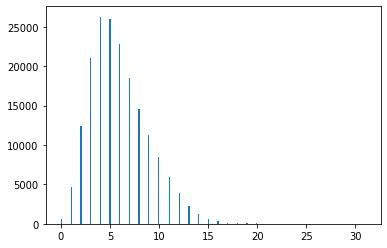

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(df_train.text.apply(lambda text: len(text.split())), bins='auto')
hist

In [75]:
word_count = 12000

In [83]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

токенизация, выделение в переменную максимальное кол-во токенов, максимальная длина твита

In [91]:
tokenizer = Tokenizer(num_words=8000+1, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)



In [92]:
tokenizer

In [93]:
word_count, training_length

(96560, 31)

In [94]:
num_classes = 2
y_train = keras.utils.to_categorical(df_train["class"], num_classes)
y_val = keras.utils.to_categorical(df_val["class"], num_classes)

In [109]:
import time
def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    return "{0:02d}:{1:02d}:{2:02d}".format(h, m, s)
#    print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

# Свертки

In [95]:
num_classes = 2

# Training
epochs = 10
batch_size = 512
print_batch_n = 100

In [96]:
model = Sequential()
model.add(Embedding(input_dim=word_count, output_dim=30, input_length=training_length))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 30)            2896800   
                                                                 
 conv1d_4 (Conv1D)           (None, 29, 128)           11648     
                                                                 
 activation_10 (Activation)  (None, 29, 128)           0         
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 10)                1290      
                                                                 
 activation_11 (Activation)  (None, 10)                0         
                                                      

In [97]:
# res

In [98]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [110]:
%%time
start = time.time()
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])
end = time.time()
time_con = exec_time(start,end)

Epoch 1/10
319/319 [==============================] - 15s 47ms/step - loss: 0.4889 - accuracy: 0.7605 - val_loss: 0.5560 - val_accuracy: 0.7142
Epoch 2/10
319/319 [==============================] - 14s 43ms/step - loss: 0.4396 - accuracy: 0.7926 - val_loss: 0.5789 - val_accuracy: 0.7094
Wall time: 28.7 s


In [111]:
time_con

'00:00:29'

In [33]:
res

,model,Test_score,Test_accuracy
0,SimpleRNN,0.693551,0.501609
1,Свертки,1.510216,0.707667
2,LSTM,1.794874,0.703743
3,GRU,0.625548,0.727770
4,model_bi,0.613900,0.739276


In [114]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])
# res['model'] = 'Свертки'
# res['Test_score'] = score[0]
# res['Test_accuracy'] = score[1]
result = {'model':'Свертки_N_8000', 'Test_score': score[0], 'Test_accuracy': score[1], 'time':time_con}
res = res.append(result,ignore_index=True)


45/45 [==============================] - 1s 12ms/step - loss: 0.5851 - accuracy: 0.7089


Test score: 0.5850539207458496
Test accuracy: 0.7089450359344482


In [115]:
res

,model,Test_score,Test_accuracy,time
0,SimpleRNN,0.693551,0.501609,NaN
1,Свертки,1.510216,0.707667,NaN
2,LSTM,1.794874,0.703743,NaN
3,GRU,0.625548,0.727770,NaN
4,model_bi,0.613900,0.739276,NaN
5,NaN,0.559150,0.718600,NaN
6,Свертки_N,0.559150,0.718600,NaN
7,SimpleRNN_N,0.694552,0.492483,NaN
8,LSTM_N,0.553618,0.718335,NaN
9,GRU_N,0.561338,0.719482,NaN


# RNN

## SimpleRNN

In [116]:
model_rnn = Sequential()

model_rnn.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model_rnn.add(Masking(mask_value=0.0))

model_rnn.add(SimpleRNN(64))
model_rnn.add(Dense(64, activation='relu'))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(2, activation='sigmoid'))

model_rnn.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_rnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 31, 30)            2896800   
                                                                 
 masking_4 (Masking)         (None, 31, 30)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                6080      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 2)                 130       
                                                                 
Total params: 2,907,170
Trainable params: 2,907,170
No

In [117]:
%%time
start = time.time()
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])
end = time.time()
time_con = exec_time(start,end)

Epoch 1/10
319/319 [==============================] - 15s 48ms/step - loss: 0.3814 - accuracy: 0.8274 - val_loss: 0.6280 - val_accuracy: 0.7056
Epoch 2/10
319/319 [==============================] - 14s 43ms/step - loss: 0.3199 - accuracy: 0.8622 - val_loss: 0.6971 - val_accuracy: 0.6978
Wall time: 29.2 s


In [118]:
score = model_rnn.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])
result = {'model':'SimpleRNN_N_8000', 'Test_score': score[0], 'Test_accuracy': score[1], 'time': time_con}
res = res.append(result,ignore_index=True)

45/45 [==============================] - 1s 9ms/step - loss: 0.6971 - accuracy: 0.4954


Test score: 0.6970599293708801
Test accuracy: 0.4954371154308319


## lstm

In [119]:
%%time
start = time.time()
model_lstm = Sequential()

model_lstm.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model_lstm.add(Masking(mask_value=0.0))
model_lstm.add(LSTM(64, recurrent_dropout=0.2))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(2, activation='sigmoid'))

model_lstm.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model_lstm.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])
end = time.time()
time_con = exec_time(start,end)

Epoch 1/10
319/319 [==============================] - 43s 124ms/step - loss: 0.5999 - accuracy: 0.6703 - val_loss: 0.5579 - val_accuracy: 0.7101
Epoch 2/10
319/319 [==============================] - 38s 119ms/step - loss: 0.5440 - accuracy: 0.7255 - val_loss: 0.5523 - val_accuracy: 0.7157
Wall time: 1min 21s


In [120]:
score = model_lstm.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])
result = {'model':'LSTM_N_8000', 'Test_score': score[0], 'Test_accuracy': score[1], 'time':time_con}
res = res.append(result,ignore_index=True)

45/45 [==============================] - 1s 20ms/step - loss: 0.5570 - accuracy: 0.7094


Test score: 0.556999146938324
Test accuracy: 0.709385871887207


## GRU

In [121]:
start = time.time()
model_gru = Sequential()

model_gru.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model_gru.add(Masking(mask_value=0.0))
model_gru.add(GRU(64, recurrent_dropout=0.2))
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(2, activation='sigmoid'))

model_gru.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model_gru.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])
end = time.time()
time_con = exec_time(start,end)

Epoch 1/10
319/319 [==============================] - 50s 149ms/step - loss: 0.5958 - accuracy: 0.6759 - val_loss: 0.5568 - val_accuracy: 0.7096
Epoch 2/10
319/319 [==============================] - 33s 102ms/step - loss: 0.5430 - accuracy: 0.7255 - val_loss: 0.5515 - val_accuracy: 0.7146


In [122]:
score = model_gru.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])
result = {'model':'GRU_N_8000', 'Test_score': score[0], 'Test_accuracy': score[1],'time':time_con}
res = res.append(result,ignore_index=True)

45/45 [==============================] - 1s 17ms/step - loss: 0.5553 - accuracy: 0.7135


Test score: 0.5552549958229065
Test accuracy: 0.7135299444198608


# CNN -> RNN

In [ ]:
start = time.time()
...
...
end = time.time()
time_con = exec_time(start,end)

In [123]:
%%time
start = time.time()
model_bi = Sequential()

model_bi.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model_bi.add(Conv1D(30, 3, padding = 'same'))
model_bi.add(Activation("tanh"))
model_bi.add(MaxPool1D(pool_size=3, strides=3))
model_bi.add(Masking(mask_value=0.0))
model_bi.add(LSTM(64, recurrent_dropout=0.2))
model_bi.add(Dense(64, activation='relu'))
model_bi.add(Dropout(0.5))
model_bi.add(Dense(2, activation='sigmoid'))

model_bi.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model_bi.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])
end = time.time()
time_con = exec_time(start,end)

Epoch 1/10
319/319 [==============================] - 27s 78ms/step - loss: 0.6058 - accuracy: 0.6577 - val_loss: 0.5561 - val_accuracy: 0.7085
Epoch 2/10
319/319 [==============================] - 25s 79ms/step - loss: 0.5326 - accuracy: 0.7337 - val_loss: 0.5476 - val_accuracy: 0.7160
Wall time: 52.7 s


In [124]:
score = model_bi.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])
result = {'model':'model_bi_N_8000', 'Test_score': score[0], 'Test_accuracy': score[1], 'time': time_con}
res = res.append(result,ignore_index=True)

45/45 [==============================] - 0s 10ms/step - loss: 0.5536 - accuracy: 0.7144


Test score: 0.5535793304443359
Test accuracy: 0.7143675684928894


In [125]:
res

,model,Test_score,Test_accuracy,time
0,SimpleRNN,0.693551,0.501609,NaN
1,Свертки,1.510216,0.707667,NaN
2,LSTM,1.794874,0.703743,NaN
3,GRU,0.625548,0.727770,NaN
4,model_bi,0.613900,0.739276,NaN
5,NaN,0.559150,0.718600,NaN
6,Свертки_N,0.559150,0.718600,NaN
7,SimpleRNN_N,0.694552,0.492483,NaN
8,LSTM_N,0.553618,0.718335,NaN
9,GRU_N,0.561338,0.719482,NaN


Данных видимо мало и они не очень хорошие, в первый раз модель lstm на плохо обработанных данных я убрал остановку по валидации и модель заметно переобучилась, на трейне была точность 0.98, а на тесте 0.7 и не увеличивалась, после предобработки текста которая убрала числа, не нужные знаки, это модели с префиксом _N результат в некоторых стал лучше, но не значительно, можно сказать, что осталось также  
   
Модели с префиксом _ N _ 8000 это модели обучающиеся на 8000 токенах самых популярных, но опять же результат у всех одинаковый  
  
Хуже всех показала себя simple_rnn, самая оптимальная это сверточная сеть, время в два раза меньше, а результат как у lstm и gru  
  
Интересная модель получилась обьедененная свертка и lstm, везде самый лучший результат 
  
Я думаю на хороших данных результат у lstm, lstm + свертки и gru был бы лучше  


In [126]:
# res.to_pickle('result.pkl')